In [20]:
%matplotlib inline
import numpy as np
import cv2
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import copy
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Copy paste från lab0
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 10)
        print(f"Device: {str(self.device).upper()}")

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
def evaluation_metrics(correct_predictions, total_predictions, all_targets, all_predictions, display_cm = True, filename="confusion_matrix", path = "images"):
    cm = confusion_matrix(all_targets, all_predictions)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / total_predictions
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    #auc = roc_auc_score(all_targets, [p[1] for p in all_probs])
        
    print(f"\rAccuracy    : {accuracy*100:.2f}%")
    print(f"Precision   : {precision*100:.2f}%")
    print(f"Recall      : {recall*100:.2f}%")
    print(f"F1 Score    : {f1*100:.2f}%")
    #print(f"AUC Score   : {auc*100:.2f}%")
    print(f"Specificity : {specificity*100:.2f}%")
    if display_cm:
        plt.figure(figsize=(4,4))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.title('Confusion Matrix')
        plt.savefig(f'{path}/{filename}.png')
        plt.show()
        
def compute_gradcam(model, inputs, target_layer):
    model.eval()
    gradients = []
    activations = []

    def save_gradients(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def save_activations(module, input, output):
        activations.append(output)

    target_layer.register_forward_hook(save_activations)
    target_layer.register_backward_hook(save_gradients)

    outputs = model(inputs)
    model.zero_grad()
    target_class = outputs.argmax(dim=1)
    one_hot_output = torch.zeros_like(outputs)
    one_hot_output[:, target_class] = 1
    outputs.backward(gradient=one_hot_output)

    gradients = gradients[0].cpu().data.numpy()
    activations = activations[0].cpu().data.numpy()

    weights = np.mean(gradients, axis=(2, 3))[0]
    gradcam = np.sum(weights[:, np.newaxis, np.newaxis] * activations[0], axis=0)
    gradcam = np.maximum(gradcam, 0)
    gradcam = cv2.resize(gradcam, (inputs.shape[2], inputs.shape[3]))
    gradcam -= gradcam.min()
    gradcam /= gradcam.max()
    return gradcam

In [5]:
def train_and_validate(nn, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler = None, print_seperate = False, patience=5) -> None:
    nn.to(nn.device)

    n = int(len(str(abs(num_epochs))))
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        nn.train()
        total_train_loss = 0

        ind = 0
        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(nn.device), labels.to(nn.device)

            optimizer.zero_grad()
            outputs = nn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            

            total_train_loss += loss.item()
            print(f"\rTraining.. Epoch [{epoch+1:>n}/{num_epochs:>n}], ({ind+1:>3}/{len(train_loader)})", end="")
            ind += 1

        nn.eval()
        total_val_loss = 0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            ind = 0
            for batch in val_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(nn.device), labels.to(nn.device)

                outputs = nn(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
                print(f"\rValidating Epoch [{epoch+1:>n}/{num_epochs:>n}], ({ind+1:>3}/{len(val_loader):>3})", end="")
                ind += 1



                    
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        accuracy = correct_predictions / total_predictions
        
        if scheduler:
            # reducelr... vill tydligen ha lossen exlipcitly 
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()

        print(f'\r.......... Epoch [{epoch+1:>n}/{num_epochs:>n}], ({len(val_loader):>3}/{len(val_loader):>3}), Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy*100:.2f}%', end="")
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f" Early stopping: {epochs_no_improve}/{patience}", end="")
            if epochs_no_improve >= patience:
                print(f"\nNo improvement in {epochs_no_improve} epochs, stopping early.")
                break
        # Early stopping 
        if print_seperate:
            print()
    print()

        


def test_model(nn, test_loader, display_cm = True) -> None:
    print("\rTesting...", end = "")
    nn.to(nn.device)
    nn.eval()
    
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_targets = []
    all_probs = []


    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(nn.device), labels.to(nn.device)
            outputs = nn(inputs)
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            # För F1, Rec, Pre, AUC:
            probs = torch.softmax(outputs, dim=1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())


    # Compute evalulation metrics
    evaluation_metrics(correct_predictions, total_predictions, all_targets, all_predictions, display_cm)



In [15]:

def ensemble_prediction(models: list[torch.nn.Module], inputs: torch.Tensor, scheme: str = "Majority Vote", weights = [0.2, 0.3, 0.5]):
    device = models[0].device
    for model in models:
        model.eval()
        model.to(device)


    with torch.no_grad():
        # Collect all model predictions
        predictions = [model(inputs) for model in models]

    # Normalize weights for Weighted Vote
    if weights is None:
        weights = [1.0] * len(models)
    else:
        total_weight = sum(weights)
        weights = [w / total_weight for w in weights]

    if scheme == "Majority Vote":
        # Each model votes with the class index it predicts
        pred_labels = [torch.argmax(pred, dim=1) for pred in predictions]
        stacked_labels = torch.stack(pred_labels, dim=0)
        final_pred, _ = torch.mode(stacked_labels, dim=0)
        return final_pred
    elif scheme == "Weighted Vote":
        # Apply softmax then weight the probabilities
        weighted_predictions = [weights[i] * F.softmax(pred, dim=1) for i, pred in enumerate(predictions)]
        final_pred = torch.sum(torch.stack(weighted_predictions, dim=0), dim=0)
        return final_pred
    elif scheme == "Average":
        # Apply softmax (if predictions are logits), then average
        avg_preds = torch.mean(torch.stack([F.softmax(pred, dim=1) for pred in predictions], dim=0), dim=0)
        return avg_preds  # Returning probabilities for all classes
    elif scheme == "Sum":
        # Sum of logits (assuming logits are returned)
        summed_preds = torch.sum(torch.stack(predictions, dim=0), dim=0)
        return summed_preds
    else:
        raise ValueError(f"Unknown ensemble scheme: {scheme}")
        
        # match scheme: 
        #     case "Majority Vote":
        #         predictions = [model(inputs).max(1)[1] for model in models]
        #         stacked_predictions = torch.stack(predictions, dim=0)
        #         return torch.mode(stacked_predictions, dim=0)[0]
        #     case "Average":
        #         outputs = sum(model(inputs) for model in models) / len(models)
        #         return outputs
        #     case "Weighted Average":
        #         if len(weights) != len(models):
        #             raise ValueError("Number of models and weights do not match.")
        #         weights = torch.tensor(weights, device=device)  
        #         outputs = sum(weights[i] * model(inputs) for i, model in enumerate(models))
        #         return outputs / weights.sum()
        #     case "Soft Voting":
        #         probabilities = [F.softmax(model(inputs), dim=1) for model in models]
        #         mean_probabilities = sum(probabilities) / len(models)
        #         return torch.argmax(mean_probabilities, dim=1)
        #     case _:
        #         raise ValueError(f"Invalid scheme.")
                
        #         with torch.noarg():
        # predictions = [model(inputs) for model in models]

    





def test_ensemble(models: list[torch.nn.Module], test_loader: DataLoader, scheme: str = "Majority Vote",  cm_params = (True, "confusion_matrix", "images")):
    print(f"Scheme: {scheme}")
    device = models[0].device
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_targets = []
    #all_probs = []
    #probs = None
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = ensemble_prediction(models, inputs, scheme)
            #print("Output shape:", outputs.shape)

            if scheme == "Sum":
                _, predicted = torch.max(outputs, 1)
            elif scheme == "Majority Vote":
                predicted = outputs
            elif scheme in["Weighted Vote", "Average"]:
                predicted = torch.argmax(outputs, 1)  # outputs are probabilities here


            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            #if probs is not None:
                #all_probs.extend(probs.cpu().numpy())

    evaluation_metrics(correct_predictions, total_predictions, all_targets, all_predictions, *cm_params)
    

In [8]:
local_directory = "C:/Users/hampu/Documents/kurser/år3/d7047e/images"
#local_directory = "C:/Users/hampek/Documents/school/d7047e/images"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4815], std=[0.2221]) # <-- beräknat med compute_mean_std() mean=[0.4815], std=[0.2221]
])

full_dataset = ImageFolder(root=local_directory, transform=transform)

# 80/10/10 split
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size


train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_subset_size = train_size // 3
remaining_size = train_size - 2 * train_subset_size # pga 1/3 = 0.333333... => jobbigt läge
train_dataset1, train_dataset2, train_dataset3 = random_split(train_dataset, [train_subset_size, train_subset_size, remaining_size])

batch_size = 32
num_workers = 4

# train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True,  num_workers = num_workers)

train_loader_resnet   = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True, num_workers=num_workers)
train_loader_googlenet = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True, num_workers=num_workers)
train_loader_densenet  = DataLoader(train_dataset3, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_loader   = DataLoader(val_dataset,   batch_size = batch_size, shuffle=False, num_workers = num_workers)
test_loader  = DataLoader(test_dataset,  batch_size = batch_size, shuffle=False, num_workers = num_workers)



In [9]:
def compute_mean_std(): 
    # tar fram mean och std för hela datasettet, till transform
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

    data = ImageFolder(root=local_directory, transform=transform)

    loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)

    mean = 0
    std = 0
    total_samples = 0
    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples

    print("Mean:", mean)
    print("Std:", std)

Device: CPU
.......... Epoch [1/100], ( 28/ 28), Train Loss: 0.2521, Val Loss: 0.1531, Accuracy: 95.22%
.......... Epoch [2/100], ( 28/ 28), Train Loss: 0.1304, Val Loss: 0.1126, Accuracy: 95.44%
.......... Epoch [3/100], ( 28/ 28), Train Loss: 0.1102, Val Loss: 0.1380, Accuracy: 94.31% Early stopping: 1/5
.......... Epoch [4/100], ( 28/ 28), Train Loss: 0.0888, Val Loss: 0.1687, Accuracy: 94.31% Early stopping: 2/5
.......... Epoch [5/100], ( 28/ 28), Train Loss: 0.0770, Val Loss: 0.1536, Accuracy: 94.65% Early stopping: 3/5
.......... Epoch [6/100], ( 28/ 28), Train Loss: 0.0565, Val Loss: 0.1344, Accuracy: 95.90% Early stopping: 4/5
.......... Epoch [7/100], ( 28/ 28), Train Loss: 0.0501, Val Loss: 0.1434, Accuracy: 95.22% Early stopping: 5/5
No improvement in 5 epochs, stopping early.

Accuracy    : 95.11%
Precision   : 97.98%
Recall      : 95.47%
F1 Score    : 96.71%
AUC Score   : 98.56%
Specificity : 94.01%


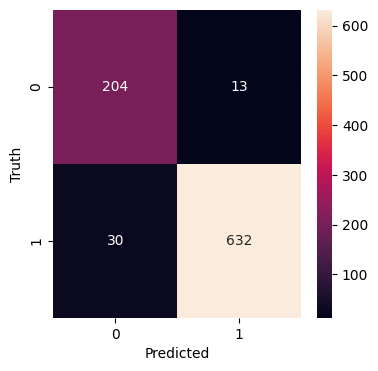

In [8]:
model = CNN()
num_epochs = 100
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, print_seperate=True)
test_model(model, test_loader)




#Accuracy    : 95.11%
#Precision   : 97.98%
#Recall      : 95.47%
#F1 Score    : 96.71%
#AUC Score   : 98.56%
#Specificity : 94.01%

In [98]:
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0256630
num_epochs = 30
learning_rate = 0.0001
criterion = torch.nn.CrossEntropyLoss()
_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Interviewer : If you want to repeat this code again, how would you do that?
#          Me : Copy paste

### FEATURE EXTRACTION ###
fe_resnet    = models.resnet18(pretrained=True)
fe_googlenet = models.googlenet(pretrained=True)
fe_densenet  = models.densenet121(pretrained=True)

fe_resnet.device    = _device
fe_googlenet.device = _device
fe_densenet.device  = _device

fe_resnet.fc           = torch.nn.Linear(fe_resnet.fc.in_features, 2)
fe_googlenet.fc        = torch.nn.Linear(fe_googlenet.fc.in_features, 2)
fe_densenet.classifier = torch.nn.Linear(fe_densenet.classifier.in_features, 2)

for name, param in fe_resnet.named_parameters():
    if "fc" not in name: 
        param.requires_grad = False
for name, param in fe_googlenet.named_parameters():
    if "fc" not in name:
        param.requires_grad = False
for name, param in fe_densenet.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

optimizer_fe_resnet    = torch.optim.Adam(fe_resnet.parameters(), lr=learning_rate)
optimizer_fe_googlenet = torch.optim.Adam(fe_googlenet.parameters(), lr=learning_rate)
optimizer_fe_densenet  = torch.optim.Adam(fe_densenet.parameters(), lr=learning_rate)

scheduler_fe_resnet    = ReduceLROnPlateau(optimizer_fe_resnet)
scheduler_fe_googlenet = ReduceLROnPlateau(optimizer_fe_googlenet)
scheduler_fe_densenet  = ReduceLROnPlateau(optimizer_fe_densenet)

### FINE TUNING ###
ft_resnet    = models.resnet18(pretrained=True)
ft_googlenet = models.googlenet(pretrained=True)
ft_densenet  = models.densenet121(pretrained=True)

ft_resnet.device    = _device
ft_googlenet.device = _device
ft_densenet.device  = _device

ft_resnet.fc           = torch.nn.Linear(ft_resnet.fc.in_features, 2)
ft_googlenet.fc        = torch.nn.Linear(ft_googlenet.fc.in_features, 2)
ft_densenet.classifier = torch.nn.Linear(ft_densenet.classifier.in_features, 2)

optimizer_ft_resnet    = torch.optim.Adam(ft_resnet.parameters(), lr=learning_rate)
optimizer_ft_googlenet = torch.optim.Adam(ft_googlenet.parameters(), lr=learning_rate)
optimizer_ft_densenet  = torch.optim.Adam(ft_densenet.parameters(), lr=learning_rate)

scheduler_ft_resnet    = ReduceLROnPlateau(optimizer_ft_resnet)
scheduler_ft_googlenet = ReduceLROnPlateau(optimizer_ft_googlenet)
scheduler_ft_densenet  = ReduceLROnPlateau(optimizer_ft_densenet)



c:\Users\hampek\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hampek\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\hampek\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weig

In [101]:
print(f"Feature extraction. . .")
feature_extraction_zip = zip(
    [          fe_resnet,           fe_googlenet,           fe_densenet],
    [optimizer_fe_resnet, optimizer_fe_googlenet, optimizer_fe_densenet],
    [scheduler_fe_resnet, scheduler_fe_googlenet, scheduler_fe_densenet],
    [train_loader_resnet, train_loader_googlenet, train_loader_densenet])

for model, optimizer, scheduler, train_loader in feature_extraction_zip:
    nn_name = model.__class__.__name__
    print(f"Network: {nn_name}")
    train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, print_seperate=True, patience=3)

    model_path = f"{nn_name.upper()}_TRAINED_FEATURE_EXTRACTION.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Saved {nn_name} to {model_path}")

    test_model(model, test_loader, display_cm = False)



Feature extraction. . .
Network: ResNet
.......... Epoch [1/30], ( 19/ 19), Train Loss: 0.5442, Val Loss: 0.4806, Accuracy: 72.65%
.......... Epoch [2/30], ( 19/ 19), Train Loss: 0.4550, Val Loss: 0.4110, Accuracy: 78.12%
.......... Epoch [3/30], ( 19/ 19), Train Loss: 0.4015, Val Loss: 0.3656, Accuracy: 82.91%
.......... Epoch [4/30], ( 19/ 19), Train Loss: 0.3596, Val Loss: 0.3345, Accuracy: 85.47%
.......... Epoch [5/30], ( 19/ 19), Train Loss: 0.3288, Val Loss: 0.3096, Accuracy: 87.01%
.......... Epoch [6/30], ( 19/ 19), Train Loss: 0.3031, Val Loss: 0.2964, Accuracy: 88.03%
.......... Epoch [7/30], ( 19/ 19), Train Loss: 0.2876, Val Loss: 0.2834, Accuracy: 88.21%
.......... Epoch [8/30], ( 19/ 19), Train Loss: 0.2706, Val Loss: 0.2742, Accuracy: 87.69%
.......... Epoch [9/30], ( 19/ 19), Train Loss: 0.2642, Val Loss: 0.2599, Accuracy: 88.89%
.......... Epoch [10/30], ( 19/ 19), Train Loss: 0.2599, Val Loss: 0.2627, Accuracy: 88.55% Early stopping: 1/3
.......... Epoch [11/30], ( 1

In [99]:
print(f"Fine tuning. . .")
fine_tuning_zip = zip(
    [          ft_resnet,           ft_googlenet,           ft_densenet],
    [optimizer_ft_resnet, optimizer_ft_googlenet, optimizer_ft_densenet],
    [scheduler_ft_resnet, scheduler_ft_googlenet, scheduler_ft_densenet],
    [train_loader_resnet, train_loader_googlenet, train_loader_densenet])

for model, optimizer, scheduler, train_loader in fine_tuning_zip:
    nn_name = model.__class__.__name__
    print(f"Network: {nn_name}")
    train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, print_seperate=True, patience=5)

    model_path = f"{nn_name.upper()}_TRAINED_FINE_TUNING.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Saved {nn_name} to {model_path}")

    test_model(model, test_loader, display_cm = False)


Fine tuning. . .
Network: ResNet
.......... Epoch [1/30], ( 19/ 19), Train Loss: 0.2106, Val Loss: 0.1238, Accuracy: 95.73%
.......... Epoch [2/30], ( 19/ 19), Train Loss: 0.0566, Val Loss: 0.1390, Accuracy: 95.56% Early stopping: 1/5
.......... Epoch [3/30], ( 19/ 19), Train Loss: 0.0321, Val Loss: 0.1717, Accuracy: 95.38% Early stopping: 2/5
.......... Epoch [4/30], ( 19/ 19), Train Loss: 0.0335, Val Loss: 0.1773, Accuracy: 96.07% Early stopping: 3/5
.......... Epoch [5/30], ( 19/ 19), Train Loss: 0.0369, Val Loss: 0.1550, Accuracy: 96.07% Early stopping: 4/5
.......... Epoch [6/30], ( 19/ 19), Train Loss: 0.0156, Val Loss: 0.1277, Accuracy: 96.07% Early stopping: 5/5
No improvement in 5 epochs, stopping early.

Saved ResNet to RESNET_TRAINED_FINE_TUNING.pth
Accuracy    : 95.91%
Precision   : 95.77%
Recall      : 98.85%
F1 Score    : 97.29%
Specificity : 87.50%
Network: GoogLeNet
.......... Epoch [1/30], ( 19/ 19), Train Loss: 0.2367, Val Loss: 0.1400, Accuracy: 94.87%
.......... Epo

In [11]:
def load_model(model_class, model_file):
    if model_class == models.googlenet:
        model = model_class(pretrained=True)
        # Adjusting the final layers of the main classifier and auxiliary classifiers
        model.fc = torch.nn.Linear(model.fc.in_features, 2)
    elif model_class == models.densenet121:
        model = model_class(pretrained=True)
        model.classifier = torch.nn.Linear(model.classifier.in_features, 2)
    else:  # Assuming ResNet or similar
        model = model_class(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, 2)
    
    model.load_state_dict(torch.load(model_file))
    model.eval()  
    print(f"Loaded {model.__class__.__name__}.")
    return model

_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#ft_resnet    = load_model(models.resnet18, "networks/RESNET_TRAINED_FINE_TUNING.pth")
#ft_googlenet = load_model(models.googlenet, "networks/GOOGLENET_TRAINED_FINE_TUNING.pth")
#ft_densenet  = load_model(models.densenet121, "networks/DENSENET_TRAINED_FINE_TUNING.pth")
fe_resnet    = load_model(models.resnet18, "networks_same/RESNET_TRAINED_FEATURE_EXTRACTION.pth")
fe_googlenet = load_model(models.googlenet, "networks_same/GOOGLENET_TRAINED_FEATURE_EXTRACTION.pth")
fe_densenet  = load_model(models.densenet121, "networks_same/DENSENET_TRAINED_FEATURE_EXTRACTION.pth")

fe_resnet.device    = _device
fe_googlenet.device = _device
fe_densenet.device  = _device
#ft_resnet.device    = _device
#ft_googlenet.device = _device
#ft_densenet.device  = _device

c:\Users\hampu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hampu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded ResNet.


c:\Users\hampu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded GoogLeNet.


c:\Users\hampu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded DenseNet.


FEATURE EXTRACTION
Scheme: Majority Vote
Accuracy    : 96.25%
Precision   : 97.67%
Recall      : 97.22%
F1 Score    : 97.44%
Specificity : 93.59%


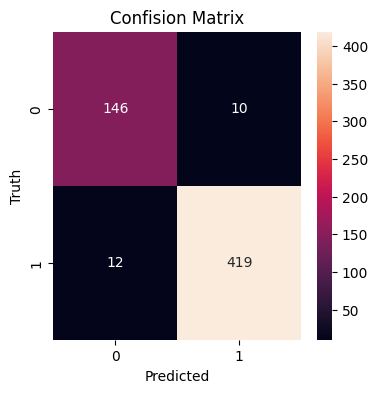

Scheme: Weighted Vote
Accuracy    : 94.89%
Precision   : 96.96%
Recall      : 96.06%
F1 Score    : 96.50%
Specificity : 91.67%


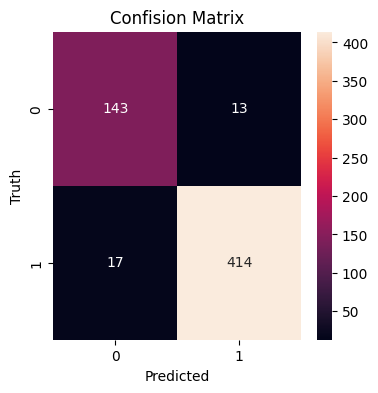

Scheme: Average
Accuracy    : 95.57%
Precision   : 97.20%
Recall      : 96.75%
F1 Score    : 96.98%
Specificity : 92.31%


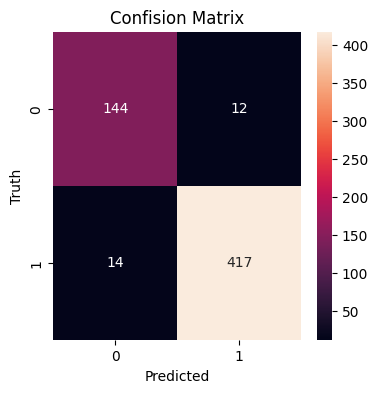

Scheme: Sum
Accuracy    : 95.40%
Precision   : 96.98%
Recall      : 96.75%
F1 Score    : 96.86%
Specificity : 91.67%


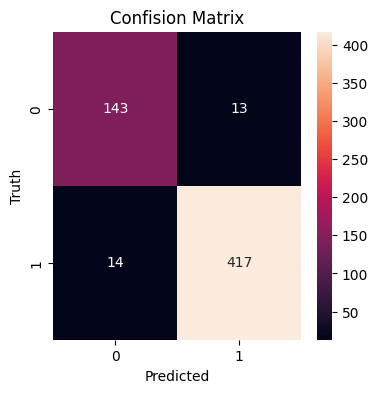

In [18]:
#"Majority Vote","Average","Weighted Vote","Sum"
#print("FINE TUNING")
#test_ensemble([ft_resnet, ft_googlenet, ft_densenet], test_loader, scheme = "Majority Vote", display_cm = True)
#test_ensemble([ft_resnet, ft_googlenet, ft_densenet], test_loader, scheme = "Weighted Vote", display_cm = True)
#test_ensemble([ft_resnet, ft_googlenet, ft_densenet], test_loader, scheme = "Average", display_cm = True)
#test_ensemble([ft_resnet, ft_googlenet, ft_densenet], test_loader, scheme = "Sum", display_cm = True)
#print("\n\n\n")
print("FEATURE EXTRACTION")
test_ensemble([fe_resnet, fe_googlenet, fe_densenet], test_loader, scheme = "Majority Vote", cm_params=(True, "FT_CM_MAJORITY_VOTE", "images"))
test_ensemble([fe_resnet, fe_googlenet, fe_densenet], test_loader, scheme = "Weighted Vote", cm_params=(True, "FT_CM_WEIGHTED_VOTE", "images"))
test_ensemble([fe_resnet, fe_googlenet, fe_densenet], test_loader, scheme = "Average", cm_params=(True, "FT_CM_AVERAGE", "images"))
test_ensemble([fe_resnet, fe_googlenet, fe_densenet], test_loader, scheme = "Sum", cm_params=(True, "FT_CM_SUM", "images"))
# test_model(ft_resnet, test_loader, display_cm = True)
# test_model(ft_googlenet, test_loader, display_cm = True)
# test_model(ft_densenet, test_loader, display_cm = True)
# test_model(fe_resnet, test_loader, display_cm = True)
# test_model(fe_googlenet, test_loader, display_cm = True)
# test_model(fe_densenet, test_loader, display_cm = True)

In [106]:
def check_model_predictions(models, test_loader):
    device = next(models[0].parameters()).device
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            for i, model in enumerate(models):
                model.eval()
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                print(f"Model {i} predictions: {predicted.cpu().numpy()}")
            break  # Check only the first batch for brevity

# Example usage
check_model_predictions([fe_resnet, fe_googlenet, fe_densenet], test_loader)

Model 0 predictions: [1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1]
Model 1 predictions: [1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1]
Model 2 predictions: [1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1]


In [105]:
print(len(train_dataset1))
print(len(train_dataset2))
print(len(train_dataset3))
print(len(val_dataset))
print(len(test_dataset))

1561
1561
1562
585
587
